# Домашнее задание 2-2. 


# Задача 2. Классификация даты документа.

Выполнил: Антипов Александр Евгеньевич, группа Б01-818

Преподаватели: Грабовой Андрей Валериевич, Воронцов Константин Вячеславович \
Благодарность за консультации: Чемров Кирилл, Троегубов Александр

# Библиотеки

In [ ]:
!pip install --quiet -U bigartm pymorphy2[fast] pyLDAvis

     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 1.7 MB 38.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.2 MB 29.1 MB/s 
     |████████████████████████████████| 371 kB 36.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re

import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import xgboost as xgb
#from torch.utils.tensorboard import SummaryWriter

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Загружаем данные

Выборка представляет собой набор новостных статей с сайта lenta.ru за 22 года:(1999--2020 гг.) \ 
Предлагается реализовать классификатор статей по году их публикации.

In [ ]:
# Директория с датасетом
DIR='/content/drive/MyDrive/Colab Notebooks/Topic_classification'

Визуализация необработанных данных

In [ ]:
data = pd.read_csv(f'{DIR}/lenta-ru-filtered.csv')
data

,text,tags,len,date
0,С 1 сентября на всей территории России вводитс...,Все,1654,31-08-1999
1,"По сведениям миссии ООН, передаваемым РИА ""Нов...",Все,1086,31-08-1999
2,15 представителей национал-большевистской парт...,Все,1219,31-08-1999
3,Намеченная на сегодняшний день церемония вступ...,Все,3094,31-08-1999
4,"На юге Киргизии, а именно в Баткенском и Чон-А...",Все,1354,31-08-1999
...,...,...,...,...
863280,Популярное место среди туристов в Мурманской о...,Россия,1231,11-09-2020
863281,Рейтинги от международного рейтингового агентс...,NaN,1425,11-09-2020
863282,Российские ученые нашли в Якутии новый подвид ...,События,1299,11-09-2020
863283,Для указания коронавируса как причины смерти ч...,Общество,2061,11-09-2020


In [ ]:
data.describe()

,len
count,863285.000000
mean,1341.245505
std,572.066583
min,3.000000
25%,980.000000
50%,1253.000000
75%,1596.000000
max,55387.000000


Средняя длина документа - полтора Кб

## Предобработка текстов
Препроцесинг занимает порядка двух часов (из-за лематизации), поэтому загружается сразу обработанная версия

Препроцессинг включает в себя:
1. разбиение текста документов на слова, причем знаки препинания и спецсимволы составляют отдельные токены
2. Использование лемманизатора, приводящего слова в нормальную форму (без падежей)
3. Удаление стоп-слов - слов, смысл которых не важен при определении темы документа.

Текст уже был обработан в рамках семинара, потому будем использовать уже готовый результат.

### Токенизаторы

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
word_tokenizer = RegexpTokenizer(r'[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = lambda sent: nltk.sent_tokenize(sent, language="russian")

###Лематизатор для русского

In [ ]:
nltk.download('stopwords')
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

In [ ]:
DO_PREPROC=False # используем уже готовый результат, загруженный с внешнего диска

In [ ]:
if DO_PREPROC:
    data_text = data['text']
    for i in tqdm(range(len(data))):
        data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
    data.to_csv(f'{DIR}/results_new/lenta-ru-proccess.csv', index=False)
else:   # load preprocessed and presaved data
    data = pd.read_csv(f'{DIR}/lenta-ru-proccess.csv')
    data

In [ ]:
print(data)

                                                     text      tags   len  \
0       1 сентябрь весь территория россия вводиться но...       Все  1654   
1       сведение миссия оон , передаваемый риа " новос...       Все  1086   
2       15 представитель национал - большевистский пар...       Все  1219   
3       наметить сегодняшний день церемония вступление...       Все  3094   
4       юг киргизия , именно баткенский чон - алайском...       Все  1354   
...                                                   ...       ...   ...   
863280  популярный место среди турист мурманский облас...    Россия  1231   
863281  рейтинг международный рейтинговый агентство s ...       NaN  1425   
863282  российский учёный найти якутия новый подвид ар...   События  1299   
863283  указание коронавирус причина смерть человек не...  Общество  2061   
863284  президент сша дональд трамп стать посредник но...  Политика  1020   

              date  
0       31-08-1999  
1       31-08-1999  
2       31-0

# BigARTM
Библиотека `BigARTM` преобразует исходный `csv` формат в `vw` формат. Текст преобразуется в последовательность, состоящую из:
1. Идентификатора документа
2. Текста (дефолтной модальности)
3. Последовательности модальностей, каждая из которых имеет вид `|@<tag> <val>`

## Перевод данных в формат данных для bigartm (+ деление на train/valid)
Также воспользуемся готовым результатом.

In [ ]:
!mkdir '/content/drive/MyDrive/Colab Notebooks/Topic_classification/results_new/vw_data'

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/Topic_classification/results_new/vw_data’: File exists


In [ ]:
filename_valid = (f'{DIR}/results_new/vw_data/texts_valid.vw.txt')
filename_train = (f'{DIR}/results_new/vw_data/texts_train.vw.txt')

In [ ]:
DO_PREPROC_FOR_BIGARTM=False
if DO_PREPROC_FOR_BIGARTM:
    counter_train = 0
    counter_valid = 0

    y_train = []
    y_valid = []

    reg = re.compile(r'\W+')
    with open(filename_valid, 'w') as fout_valid:
        with open(filename_train, 'w') as fout_train:
            for i in tqdm(range(len(data))):
                text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
                month = data.loc[i]['date'].split('-')[1]
                year =  data.loc[i]['date'].split('-')[2]
                tag =   str(data.loc[i]['tags']).lower().strip()

                if len(text) > 100:
                    if (i + 1) % 100 == 0:  # test (valid) // without year
                        fout_valid.write('doc_{} {} |@tag class_{} |@month class_{}\n'.format(
                            counter_valid, ' '.join(text), tag, month))
                        counter_valid += 1
                        y_valid.append(year)
                    else:                   # train
                        fout_train.write('doc_{} {} |@tag class_{} |@month class_{} |@year class_{}\n'.format(
                            counter_train, ' '.join(text), tag, month, year))
                        counter_train += 1
                        y_train.append(year)

    with open(f'{DIR}/results_new/vw_data/y_valid.vw.txt', 'w') as f:
        f.write('\n'.join(y_valid))

    with open(f'{DIR}/results_new/vw_data/y_train.vw.txt', 'w') as f:
        f.write('\n'.join(y_train))
else: # load presaved y (answers)
    with open(f'{DIR}/results_new/vw_data/y_valid.vw.txt') as f:
        y_valid = f.read().split('\n')

    with open(f'{DIR}/results_new/vw_data/y_train.vw.txt') as f:
        y_train = f.read().split('\n')

In [ ]:
!head -2 '/content/drive/MyDrive/Colab Notebooks/Topic_classification/results_new/vw_data/texts_train.vw.txt'

doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

# Создаем батчи
Делаем, как в семинаре, т.е. используем готовый результат для экономии времени.

In [ ]:
!mkdir '/content/drive/MyDrive/Colab Notebooks/Topic_classification/results_new/vw_batches'

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/Topic_classification/results_new/vw_batches’: File exists


In [ ]:
CREATE_NEW_BATCHES=False
if CREATE_NEW_BATCHES:
    bv_train = artm.BatchVectorizer(
        data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000, # сколько параллельно нужно подать для градиентного спуска (в док-ах)
        target_folder=f'{DIR}/results_new/vw_batches/batches_train', )

    bv_test = artm.BatchVectorizer(
        data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000, 
        target_folder=f'{DIR}/results_new/vw_batches/batches_valid')
else: # Load presaved batches
    bv_train = artm.BatchVectorizer(data_path=f'{DIR}/results_new/vw_batches/batches_train',
                                    data_format='batches')
    bv_valid = artm.BatchVectorizer(data_path=f'{DIR}/results_new/vw_batches/batches_valid',
                                    data_format='batches')

# Создаем словарь токенов

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=f'{DIR}/results_new/vw_batches/batches_train')
dictionary

artm.Dictionary(name=5f083c57-34f1-4a64-85fe-4b798456f773, num_entries=548554)

In [ ]:
print(dictionary)

artm.Dictionary(name=df2572f5-0d16-48b8-81fb-8814ef0f546e, num_entries=548554)


# ARTM модель

Модель на вход принимает `vm` данные, а на выходе формиркуется тензор - векторное распределение тем в документах. Т.е. один документ - вектор, координатами которого являются вероятности принадлежности к теме.

Используется только модальность самого текста, без регуляризаторов. \
Обучаем новую модель или загружаем обученную.

In [ ]:
!mkdir '/content/drive/MyDrive/Colab Notebooks/Topic_classification/results_new/model'

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/Topic_classification/results/model’: File exists


In [ ]:
TRAIN_NEW_MODEL=False # обучается 48мин

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100, # на самом деле число тем в выборке чуть меньше, главное, что мы все рассмотрели
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, 
                             })
    # список метрик, получаемых во время обучения
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10)) # выдает топ 10 слов, характеризующих тему

    iterator = tqdm(range(0,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default_REG-no_{i}it')
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default_REG-no_9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)

## Метрики в процессе обучения

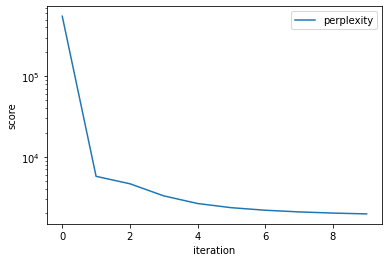

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

Видно, что перфлексия стабилизируется с 7й итерации.

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'который', 'это', 'мочь', 'человек', 'исследователь', 'клетка', 'алкоголь', 'вещество']
['бой', 'фунт', 'аукцион', 'продать', 'год', 'поединок', 'выставить', 'чемпион', 'картина', 'боксёр']
['который', 'фотография', 'свой', 'пользователь', 'человек', 'ресторан', 'весь', 'снимка', 'продукт', 'слово']
['церковь', 'министерство', 'который', 'религиозный', 'иванов', 'православный', 'инициатива', 'это', 'академия', 'весь']
['закон', 'документ', 'правительство', 'должный', 'законопроект', 'принять', 'запрет', 'это', 'срок', 'год']
['украина', 'россия', 'крым', 'российский', 'это', 'заявить', 'президент', 'страна', 'киев', 'украинский']
['пост', 'бывший', 'глава', 'должность', 'министр', 'отставка', 'занимать', 'заместитель', 'который', 'стать']
['служба', 'государственный', 'деятельность', 'власть', 'контроль', 'это', 'россия', 'год', 'сми', 'иностранный']
['директор', 'театр', 'культура', 'генеральный', 'год', 'спектакль', 'руководитель', 'который', 'артист', 'имя

## Получаем тематические вектора
Тематические вектора используются в качестве входных данных для разных классификаторов (которые мы будем сравнивать)

Один документ - вектор, координатами которого являются вероятности принадлежности к теме.

In [ ]:
X_train_pd = model.transform(bv_train) # порядка 3мин

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор

Логистическая регрессия

In [ ]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.50      0.18      0.26        39
                 nan       0.45      0.18      0.25       208
          автобизнес       1.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       0.44      0.17      0.24        24
              бизнес       0.29      0.03      0.05        70
          бокс и мма       0.56      0.31      0.40        32
                вещи       1.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       0.40      0.12      0.19        16
                 все       0.62      0.88      0.73      3356
             гаджеты       0.24      0.21      0.22        24
               город       1.00      0.00      0.00        18
        госэкономика       0.53      0.31      0.39       162
                дача       0.00      0.00      0.00        13
       

Random Forest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.23      0.26      0.24        39
                 nan       0.30      0.15      0.20       208
          автобизнес       1.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       0.38      0.21      0.27        24
              бизнес       0.21      0.06      0.09        70
          бокс и мма       0.71      0.47      0.57        32
                вещи       0.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       0.33      0.19      0.24        16
                 все       0.63      0.95      0.76      3356
             гаджеты       0.75      0.12      0.21        24
               город       0.00      0.00      0.00        18
        госэкономика       0.48      0.28      0.36       162
                дача       1.00      0.00      0.00        13
       

In [ ]:
classifier = RandomForestClassifier(n_estimators=20)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.41      0.18      0.25        39
                 nan       0.55      0.17      0.26       208
          автобизнес       1.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       0.56      0.21      0.30        24
              бизнес       0.33      0.04      0.08        70
          бокс и мма       0.94      0.47      0.62        32
                вещи       1.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       1.00      0.12      0.22        16
                 все       0.62      0.97      0.76      3356
             гаджеты       0.60      0.12      0.21        24
               город       1.00      0.00      0.00        18
        госэкономика       0.53      0.26      0.35       162
                дача       1.00      0.00      0.00        13
       

XGBoost

На всей выборке обучается слишком долго, а на фрагменте результат не лучше, чем на логистической регресии или RandomForest

In [ ]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train_np[:20000], y_train_np[:20000])
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.24      0.10      0.14        39
                 nan       0.48      0.14      0.22       208
          автобизнес       1.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       0.40      0.33      0.36        24
              бизнес       0.50      0.07      0.12        70
          бокс и мма       0.85      0.72      0.78        32
                вещи       0.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       0.50      0.06      0.11        16
                 все       0.64      0.92      0.76      3356
             гаджеты       0.57      0.17      0.26        24
               город       0.50      0.06      0.10        18
        госэкономика       0.53      0.31      0.39       162
                дача       1.00      0.08      0.14        13
       

Таким образом, все регуляризаторы работают приблизительно одинаково. В качестве классификатора будем использовать `RandomForest` с 10 деревьями - он дает хороший результат за разумное время.

# Мультимодальная модель (веса: 10, 10)
Добавим модальности месяца (@month с весом 10) и топика статьи (@tag с весом 10), без регуляризаторов

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 10.0,
                             '@month': 10.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))

    iterator = tqdm(range(0,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag10-month10_REG-no_{i}it')
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default-tag10-month10_REG-no_9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

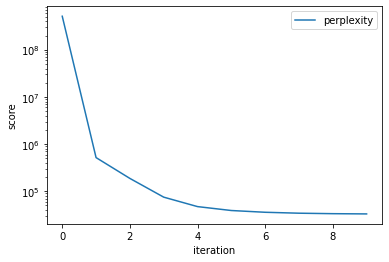

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

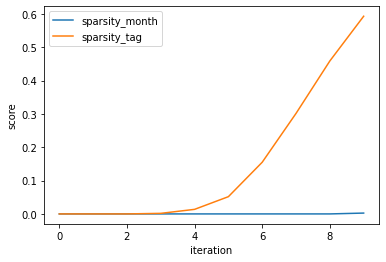

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

Видим, что при равных весах роль модальности по темам существенна, тогда как модальность по месяцу фактически ни на что не влияет. Это ожидаемо, т.к. производится классификация

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

KeyError: ignored

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор

RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

NameError: ignored

# Мультимодальная модель (веса: 5, 2)
Добавим модальности месяца (@month с весом 2) и топика статьи (@tag с весом 5), без регуляризаторов

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 2.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))

    iterator = tqdm(range(0,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-no_{i}it')
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-no_9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

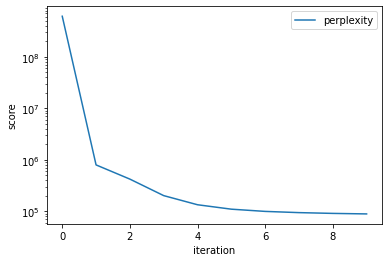

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

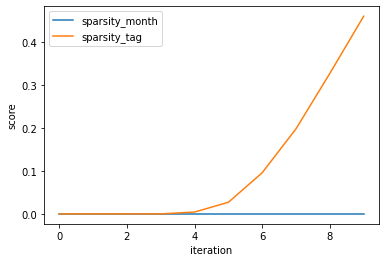

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

## Классификатор

RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

# Мультимодальная модель (разные веса: 2, 5)
Добавим модальности месяца (@month с весом 5) и топика статьи (@tag с весом 2), без регуляризаторов

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 2.0,
                             '@month': 5.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))

    iterator = tqdm(range(0,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag2-month5_REG-no_{i}it')
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default-tag2-month5_REG-no_9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

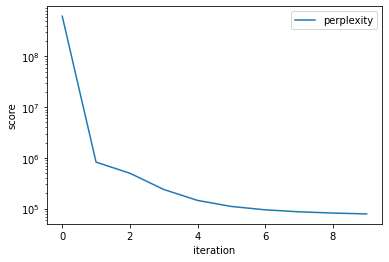

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

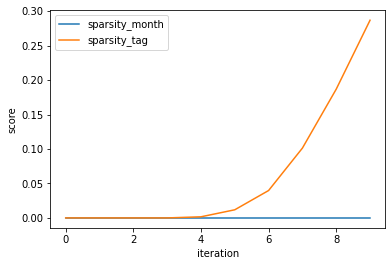

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

KeyError: ignored

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

## Классификатор

RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

NameError: ignored

# Модель с регуляризаторами (Sparse + Decorrelator)

Как и в предыдущей модели, добавим модальности месяца (@month) и топика статьи (@tag). Кроме того, будем постепенно включать регуляризаторы: первые 4 итерации разреживающий (Sparse), затем, не выключая предыдущий, добавим декоррелирующий (Decorrelator) и обучим еще 11 итераций.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 2.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    
    # First regularizer (Sparse) -- 4 iterations
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer',
                                                      tau=-0.1, #sparse
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(0,4))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-sparse{i}it-decor0it')
    
    # Add second regularizer (Decorrelator) -- 11 iterations
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer',
                                                      tau=10000,
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(4,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })

        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-sparse{i}it-decor{i}it')
    
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-sparse9it-decor9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

## Метрики в процессе обучения

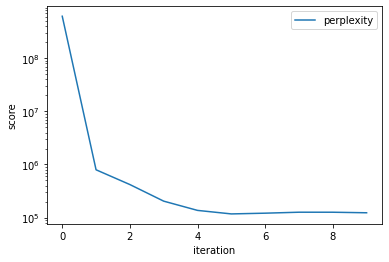

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

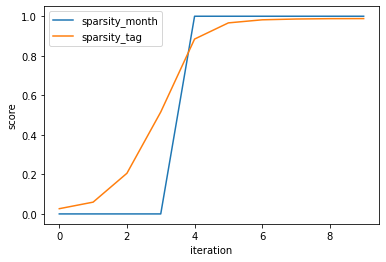

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.26      0.13      0.17        39
                 nan       0.32      0.18      0.23       208
          автобизнес       1.00      0.00      0.00         2
     аналитика рынка       0.00      1.00      0.00         0
   английский футбол       1.00      0.00      0.00         1
          белоруссия       0.56      0.21      0.30        24
              бизнес       0.14      0.07      0.10        70
          бокс и мма       0.78      0.56      0.65        32
                вещи       0.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       0.25      0.19      0.21        16
                 все       0.64      0.95      0.76      3356
             гаджеты       1.00      0.21      0.34        24
               город       0.00      0.00      0.00        18
        госэкономика       0.45      0.24      0.31       162
       

# Модель с регуляризаторами (Smooth + Decorrelator)

Как и в предыдущей модели, добавим модальности месяца (@month) и топика статьи (@tag). Кроме того, будем постепенно включать регуляризаторы: первые 4 итераций сглаживающий (Smooth), затем, не выключая предыдущий, добавим декоррелирующий (Decorrelator) и обучим еще 11 итераций.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 2.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    
    # First regularizer (Smooth) -- 8 iterations
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth_sparse_phi_regularizer',
                                                      #tau=-0.1, #sparse
                                                      tau=10,  #smooth
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(0,4))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-smooth{i}it-decor0it')
    
    # Add second regularizer (Decorrelator) -- 12 iterations
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer',
                                                      tau=10000,
                                                      class_ids=['@default_class', '@month', '@tag']))
    iterator = tqdm(range(4,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],
                              })

        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-smooth{i}it-decor{i}it')
    
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2_REG-smooth9it-decor9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    #model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

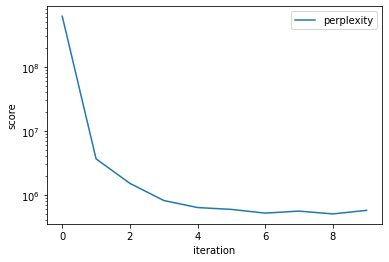

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

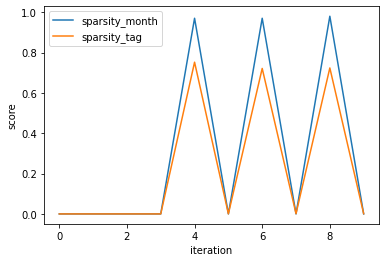

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

# Модель с модальностью года
Как и раньше, добавим модальности месяца (@month) и топика статьи (@tag), но теперь еще добавим модальность года (@year); без регуляризаторов.

Обучаем новую модель или загружаем обученную

In [ ]:
TRAIN_NEW_MODEL=False

In [ ]:
if TRAIN_NEW_MODEL:
    model = artm.ARTM(num_topics=100,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0,
                             '@tag': 5.0,
                             '@month': 2.0, 
                             '@year': 5.0, 
                             })
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_year', class_id='@year'))

    iterator = tqdm(range(0,10))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=1)
        iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                              'sparsity_month': model.score_tracker['sparsity_month'].value[-1],
                              'sparsity_tag': model.score_tracker['sparsity_tag'].value[-1],  
                              'sparsity_year': model.score_tracker['sparsity_year'].value[-1],  
                              })
        # save model on every iteration
        model.dump_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2-year-5_REG-no_{i}it')
else:
    model = artm.load_artm_model(f'{DIR}/results_new/model/MOD-default-tag5-month2-year-5_REG-no_9it')
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_month', class_id='@month'), overwrite=True)
    model.scores.add(artm.SparsityPhiScore(name='sparsity_tag', class_id='@tag'), overwrite=True)

## Метрики в процессе обучения

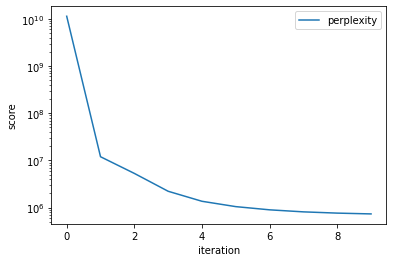

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.yscale('log')
plt.show()

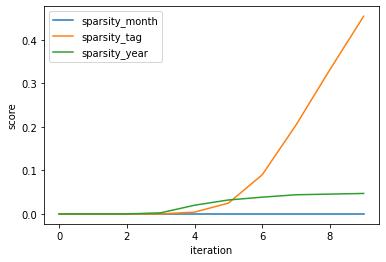

In [ ]:
plt.plot(model.score_tracker['sparsity_month'].value, label = 'sparsity_month')
plt.plot(model.score_tracker['sparsity_tag'].value, label = 'sparsity_tag')
plt.plot(model.score_tracker['sparsity_year'].value, label = 'sparsity_year')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names[:10]:
    print(top_tokens[topic_name])

['исследование', 'учёный', 'который', 'это', 'человек', 'вещество', 'алкоголь', 'исследователь', 'анализ', 'мочь']
['бой', 'аукцион', 'продать', 'поединок', 'картина', 'выставить', 'фунт', 'чемпион', 'боксёр', 'титул']
['продукт', 'ресторан', 'который', 'питание', 'собака', 'килограмм', 'еда', 'свой', 'мясо', 'заведение']
['церковь', 'религиозный', 'иванов', 'храм', 'православный', 'святой', 'который', 'русский', 'это', 'священник']
['закон', 'документ', 'должный', 'принять', 'законопроект', 'который', 'запрет', 'правительство', 'внести', 'мочь']
['украина', 'крым', 'россия', 'российский', 'это', 'территория', 'полуостров', 'украинский', 'референдум', 'страна']
['пост', 'бывший', 'глава', 'должность', 'отставка', 'занимать', 'заместитель', 'назначить', 'свой', 'министр']
['служба', 'государственный', 'деятельность', 'министерство', 'ведомство', 'федеральный', 'контроль', 'проверка', 'орган', 'сотрудник']
['директор', 'театр', 'генеральный', 'культура', 'александр', 'спектакль', 'артист

## Классификация модальности при помощи встроенного метода bigartm

Получаем матрицу условных вероятностей **p(модальность|документ)**. Остается определить наиболее вероятнуюю модальность (год) для каждого документа.

In [ ]:
year_pred_df = model.transform(batch_vectorizer=bv_valid, predict_class_id='@year').sort_index().drop(index='class_1914')
year_pred_df

,0,1,2,3,4,5,6,7,8,9,...,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603
class_2002,0.008467,0.015885,0.004914,0.001724,0.000782,0.042659,0.008010,0.019018,0.150897,0.000407,...,0.001648,0.000028,0.002765,0.000103,0.018220,0.000174,0.001831,0.000325,0.002506,0.011794
class_2003,0.018611,0.003756,0.003948,0.015861,0.034058,0.008212,0.042545,0.010692,0.002523,0.058785,...,0.004294,0.000074,0.042717,0.000167,0.007704,0.000529,0.001125,0.000193,0.003359,0.000502
class_2004,0.002777,0.012055,0.011654,0.009108,0.008199,0.049293,0.018877,0.026166,0.020381,0.002100,...,0.002166,0.000425,0.003911,0.001016,0.016324,0.004654,0.000748,0.000455,0.016504,0.004598
class_2005,0.008599,0.037315,0.003975,0.013911,0.041819,0.126878,0.053075,0.366895,0.073165,0.005037,...,0.017518,0.000210,0.011423,0.005768,0.054147,0.007955,0.007491,0.015643,0.048602,0.007182
class_2006,0.014432,0.009161,0.016638,0.028915,0.001968,0.115526,0.057036,0.018218,0.088906,0.000977,...,0.043094,0.004863,0.021518,0.003265,0.037191,0.002619,0.003596,0.000691,0.058963,0.010905
class_2007,0.013423,0.017403,0.008467,0.253468,0.008394,0.012058,0.064401,0.045731,0.010172,0.003369,...,0.000933,0.022820,0.038202,0.006003,0.264140,0.006516,0.011755,0.000929,0.057812,0.206166
class_2008,0.021080,0.122461,0.044493,0.002914,0.022169,0.015512,0.008393,0.128748,0.037944,0.007749,...,0.001353,0.003751,0.004580,0.020922,0.012855,0.010726,0.035066,0.003953,0.065799,0.020417
class_2009,0.006885,0.030019,0.026229,0.008028,0.101352,0.054630,0.023839,0.022925,0.010086,0.111392,...,0.013471,0.002386,0.005642,0.006811,0.018319,0.002374,0.029342,0.001870,0.023312,0.009854
class_2010,0.063987,0.030386,0.024553,0.023968,0.107127,0.127584,0.046772,0.052717,0.014351,0.093037,...,0.003006,0.003338,0.126229,0.012886,0.018265,0.006000,0.018392,0.003522,0.027888,0.010245
class_2011,0.049381,0.047192,0.007222,0.045198,0.050920,0.038466,0.070724,0.032176,0.006535,0.008212,...,0.001433,0.003527,0.108898,0.041202,0.132921,0.002209,0.080606,0.001835,0.019969,0.010127


In [ ]:
year_pred_np = np.array(year_pred_df)
pred = (np.argmax(year_pred_np, axis=0) + 1999).astype(str)
print(len(pred), min(pred), max(pred))

6604 1999 2017


In [ ]:
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.02      0.16      0.03        19
        2000       0.02      0.03      0.02        69
        2001       0.03      0.01      0.02        96
        2002       0.03      0.05      0.04       143
        2003       0.06      0.05      0.06       134
        2004       0.03      0.02      0.02       183
        2005       0.05      0.07      0.06       240
        2006       0.03      0.05      0.04       256
        2007       0.09      0.11      0.10       236
        2008       0.06      0.07      0.06       332
        2009       0.07      0.09      0.08       423
        2010       0.07      0.13      0.09       375
        2011       0.01      0.01      0.01       384
        2012       0.05      0.05      0.05       427
        2013       0.04      0.07      0.05       387
        2014       0.05      0.06      0.06       309
        2015       0.05      0.04      0.04       387
        2016       0.10    

## Получаем тематические вектора

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_np, y_train_np = shuffle(X_train_np, y_train_np,random_state=42)

  0%|          | 0/653795 [00:00<?, ?it/s]

KeyError: ignored

In [ ]:
X_valid_pd = model.transform(bv_valid)
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

## Классификатор
RandomForest

In [ ]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train_np, y_train_np)
pred = classifier.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=1))

# Выводы
В задании предполагалось построить модель для классификации даты (года) публикации новостных заметок из выборки lenta.ru за 22 года. В качестве векторного представления текста рассматривались тематические векторы, которые получались с помощью модели ARTM из библиотеки bigARTM. При обучении тематической модели измнялись такие параметры, как модальности (`month, year, tag`) и регуляризаторы (`smooth, sparce, decorrelator`). Также рассматривалась классификация с помощью различных классификаторов: `Logistic Regression, Random Forest, XGBoost`.

* Все классификаторы дают приблизительно равный результат ~ `60%`. В качестве основного был выбран `Random Forest, 10 trees`.
* Добавление модальностей месяца и тэга повысили точность, причем sparsity тэга во много раз превышала sparsity месяца - ожидаемо, т.к. вторая слабо влияет на тематику документа.

* Регуляризаторы добавлялись не сразу все, а постепенно, на разных итерациях. Добавление регуляризаторов не дало прироста точности.

* Добавление модальности года улучшает точность по сравнению с модальностью месяца лишь у некоторых классов, к примеру: у класса "политика".

* При наличии года  в качестве модальности есть возможность провести классификацию при помощи встроенных методов bigARTM. Можно получить матрицу условных вероятностей **p(модальность|документ)**, по которой далее определить наиболее вероятное значение модальности (года). Точность такого метода оказалась ниже других, но такой подход работает быстрее засчет простого классификатора. 

Все рассматриваемые модели показали среднюю точность классификации (~60%), что неплохо. Основной недостаток тематической классификации - неравновмерное распределение текстов по тематикам. Также некоторые тематики богаты проффесионализмами и научными терминами, что упрощает предсказание, а другие - нет.
